In [1]:
import numpy as np
import cv2
import glob
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
import pickle
import matplotlib.image as mpimg

%matplotlib inline

# Calibrating the camera

### 1. Get points from calibration images

In [ ]:
num_corners = [6,9]    # Number of inner corners in calibration images

objp = np.zeros((num_corners[0]*num_corners[1],3), np.float32)
objp[:,:2] = np.mgrid[0:num_corners[1], 0:num_corners[0]].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (num_corners[1],num_corners[0]), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (num_corners[1],num_corners[0]), corners, ret)
        clear_output()
        plt.imshow(img)
        plt.show()
        time.sleep(1)

### 2. Calculate and save distortion coefficients

In [4]:
img = cv2.imread('camera_cal/calibration5.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

# Save the camera calibration result for later use.
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/coefficients.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)

### 3. Load calibration coefficients

In [2]:
coeff = pickle.load( open( "camera_cal/coefficients.p", "rb" ) )
mtx = coeff['mtx']
dist = coeff['dist']

### 3. Test undistortion on an image

In [3]:
from utils.utils import undistort

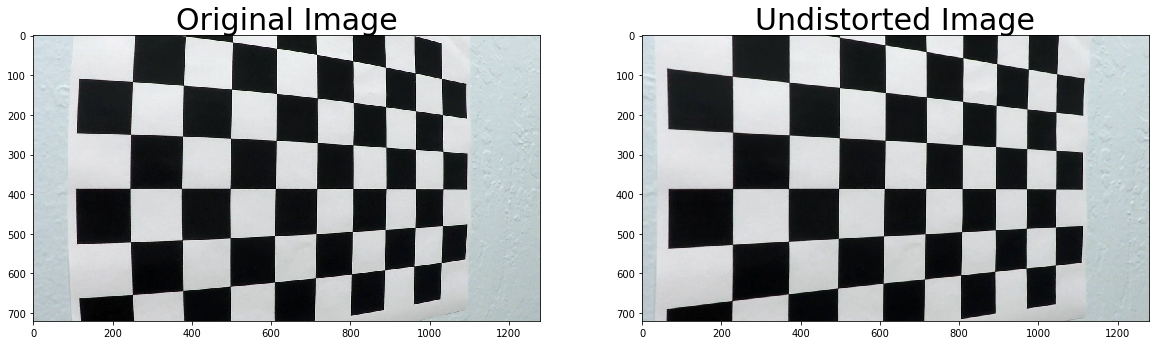

In [4]:
# Test undistortion on an image
img = cv2.imread('camera_cal/calibration5.jpg')

dst = undistort(img,mtx,dist)
cv2.imwrite('examples/test_undist.jpg',dst)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

# Transform Perspective

In [5]:
from utils.utils import get_eagle_eye, draw_points

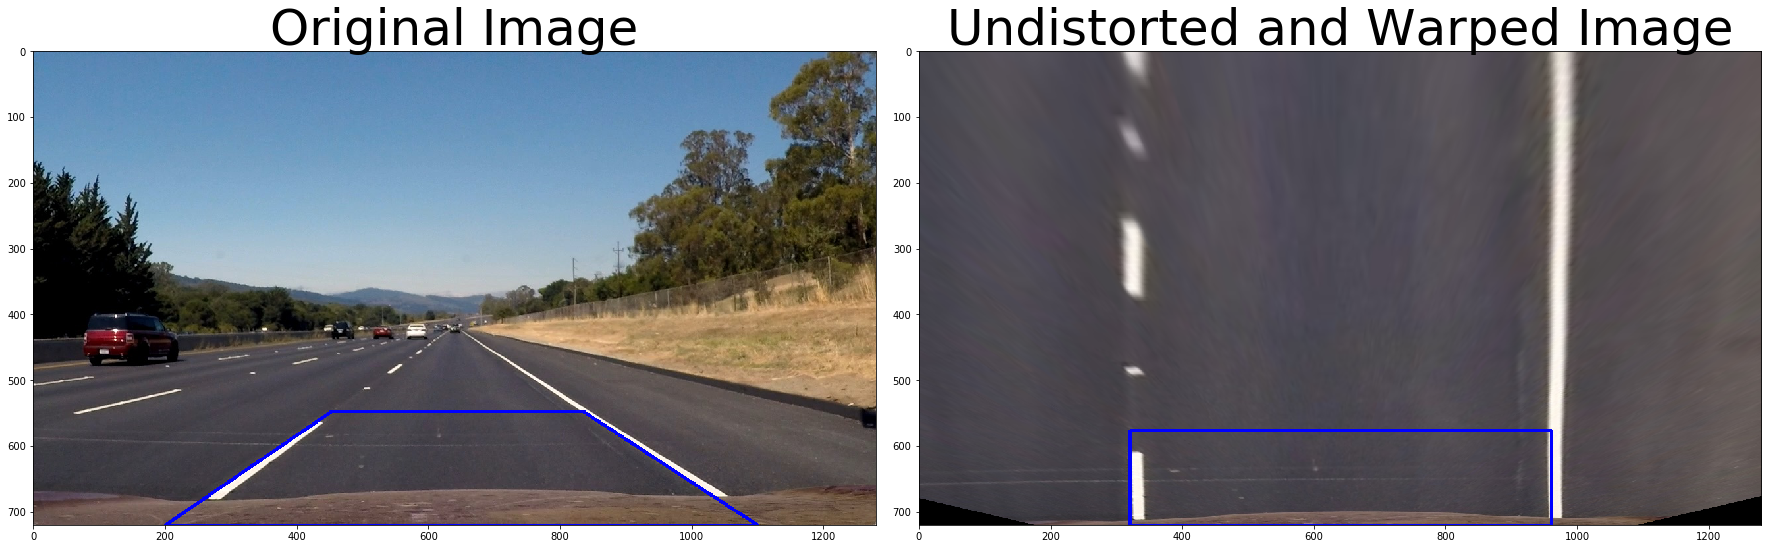

In [6]:
# Read in an image
#img = mpimg.imread('test_images/straight_lines1.jpg')
original = mpimg.imread('test_images/straight_lines2.jpg')
img = undistort(original,mtx,dist)

# Define source points for perspective transformation
src_points = np.float32([[200,720],[453,547],[835,547],[1100,720]])
# Define 4 destination points for perspective transformation
dst_points = np.float32([[320,720],[320,576],[960,576],[960,720]])

top_down = get_eagle_eye(img)

original = draw_points(original,src_points)
#original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

top_down = draw_points(top_down,dst_points)
#top_down = cv2.cvtColor(top_down, cv2.COLOR_BGR2RGB)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(original)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

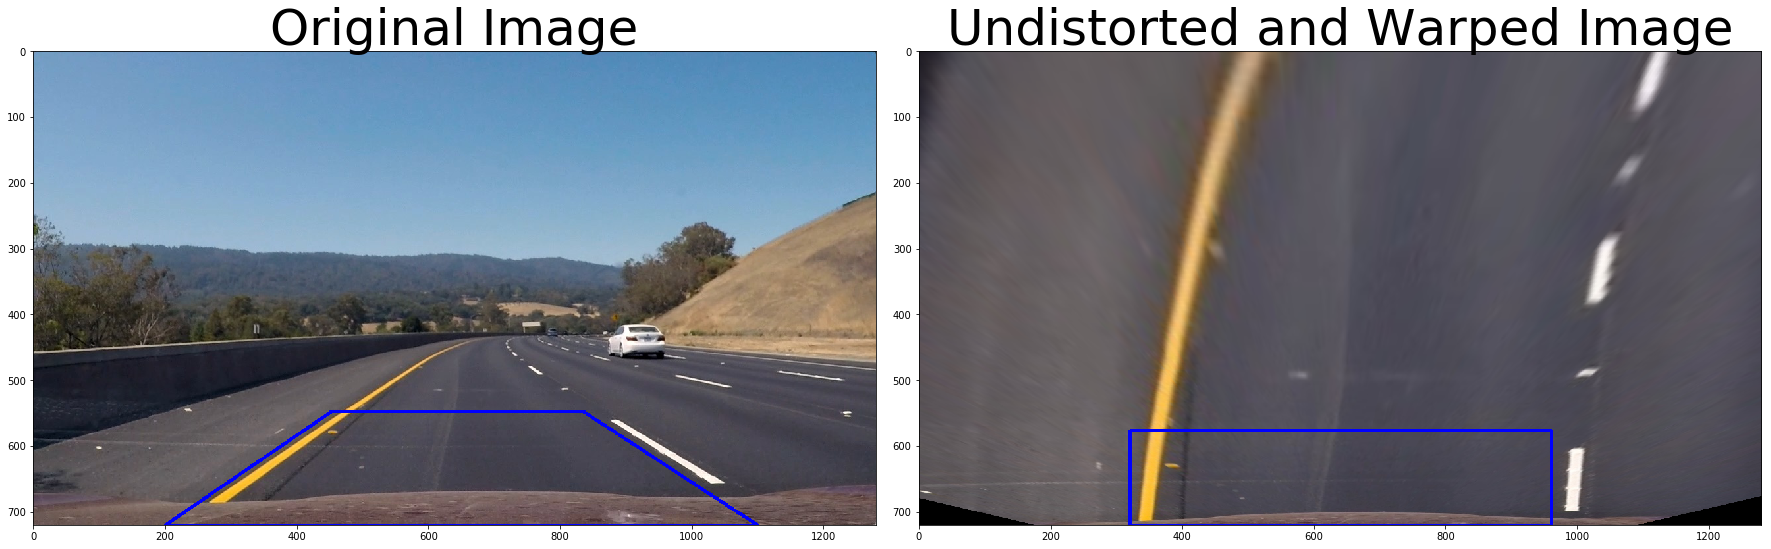

In [7]:
# Read in an image
original = mpimg.imread('test_images/test3.jpg')
img = undistort(original,mtx,dist)

top_down = get_eagle_eye(img)

original = draw_points(original,src_points)

top_down = draw_points(top_down,dst_points)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(original)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Create a thresholded binary image

The function to generate a binary thresholded image is described in the notebook Binary_Images.ipynb. We will just import the function from here on.

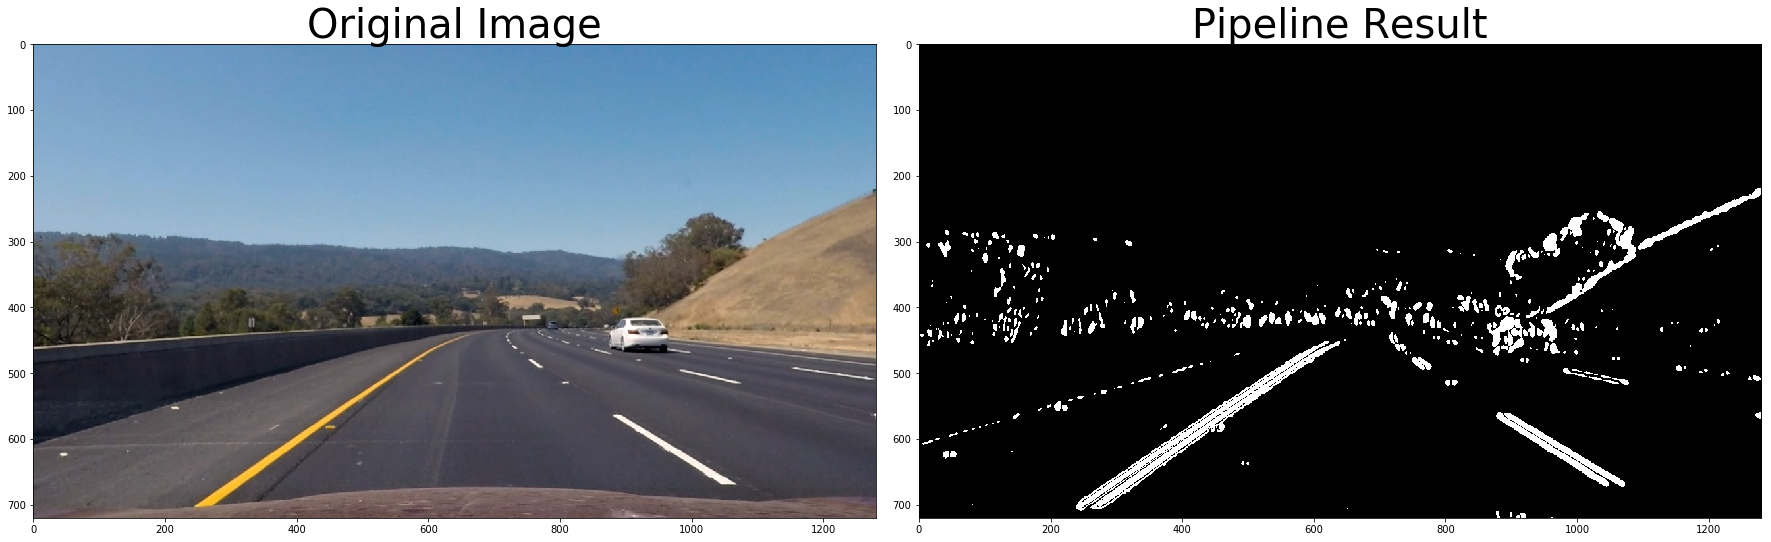

In [8]:
from utils.utils import get_binary_image
    
result = get_binary_image(img)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Processing one frame

Correct distortion + thresholding + perspective transformation

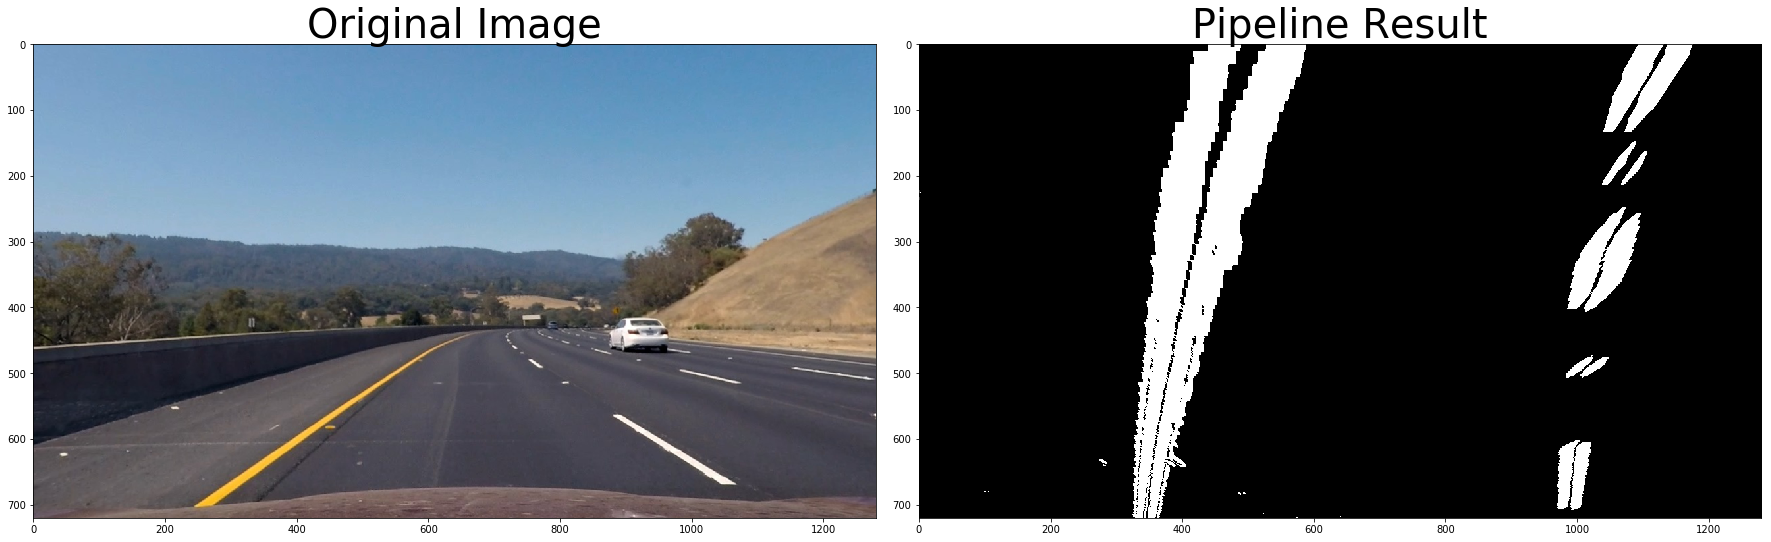

In [9]:
from utils.utils import process_frame

undistorted, thresholded, top_down = process_frame(img,mtx,dist)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(top_down, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Detecting lane pixels and fitting a polynomial

### 1. Detecting lanes origin

342 999


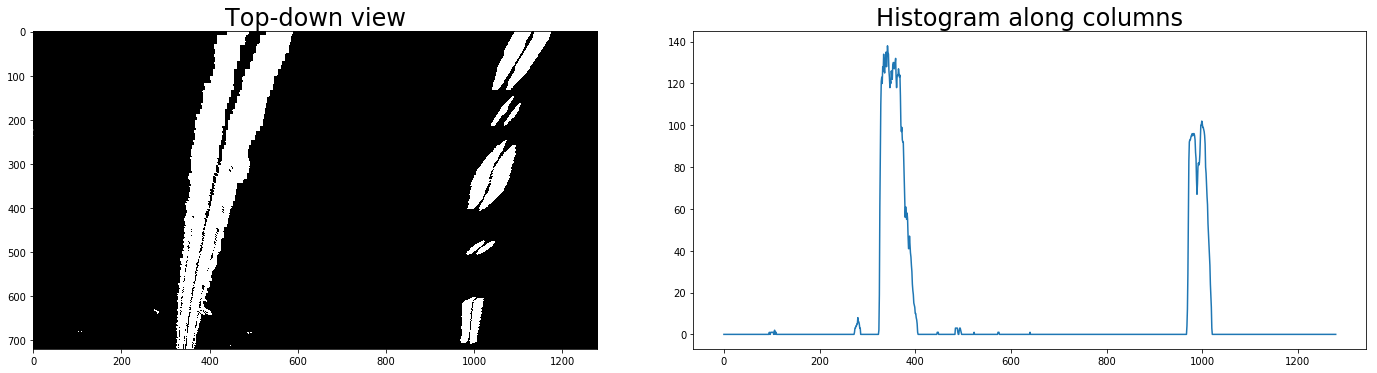

In [10]:
from utils.utils import find_lanes_hist, get_poly_from_last

histogram = np.sum(top_down[int(top_down.shape[0]*4/5):,:], axis=0)

leftx_base, rightx_base = find_lanes_hist(top_down)
print(leftx_base, rightx_base)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
f.tight_layout()

ax1.imshow(top_down, cmap='gray')
ax1.set_title('Top-down view', fontsize=24)

ax2.plot(histogram)
ax2.set_title('Histogram along columns', fontsize=24)

### Fitting a polynomial

In [21]:
from utils.utils import get_polynomial, get_polynomial2
left_fit, right_fit, left_curverad, right_curverad, out_img = get_polynomial2(top_down, leftx_base, rightx_base, margin = 100, debug=True)

(720, 0)

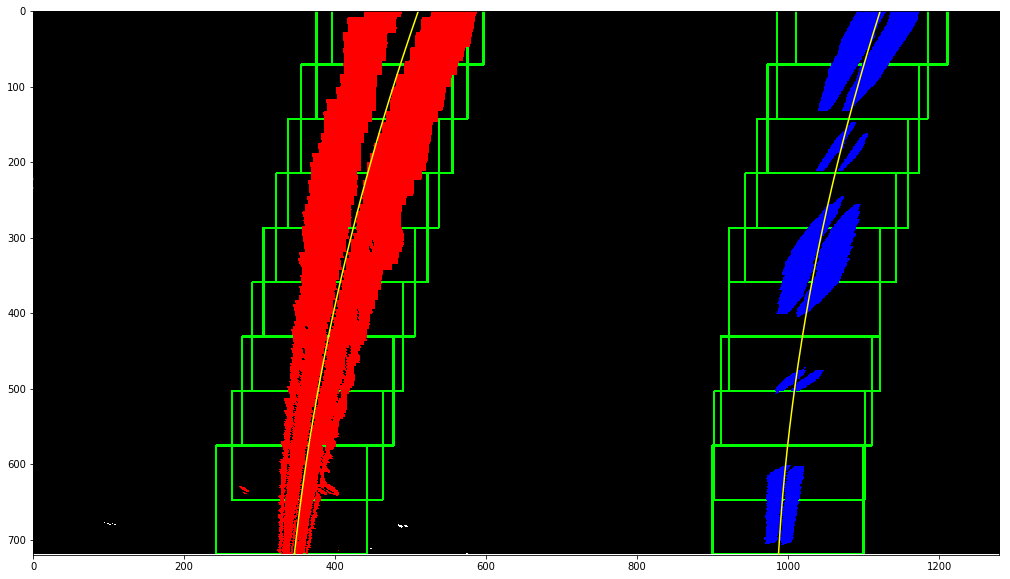

In [22]:
# Generate x and y values for plotting
ploty = np.linspace(0, top_down.shape[0]-1, top_down.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

plt.figure(figsize=(20,10))
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)


# Radius of Curvature

In [23]:
print(left_curverad, right_curverad)

990.305949501 915.932615547


# Distance to center

In [24]:
from utils.utils import find_position
dist_to_center = find_position(top_down.shape[1], left_fitx[-1], right_fitx[-1])
print(dist_to_center)

-0.141187474148


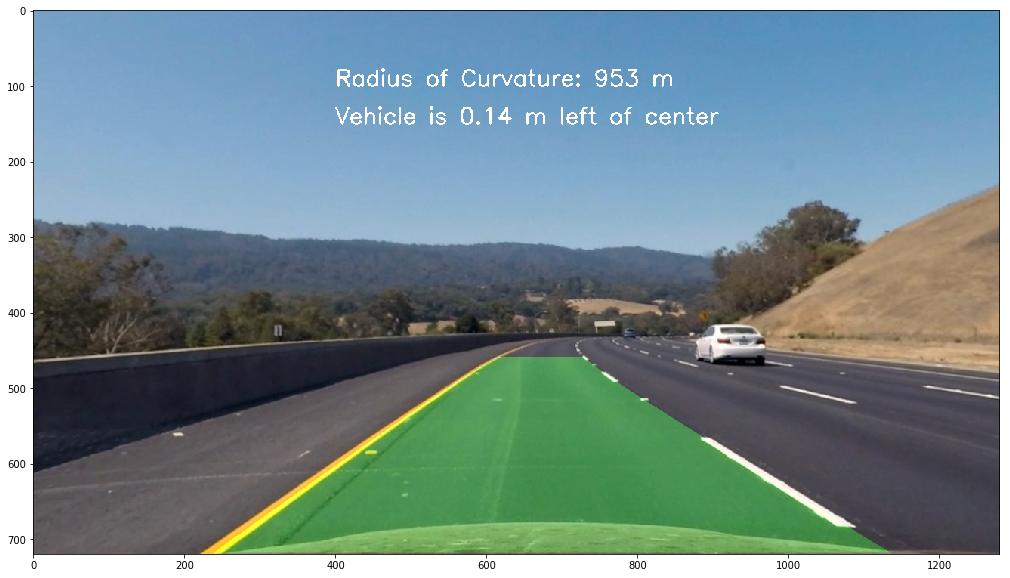

In [28]:
from utils.utils import get_inverse_transform
# Create an image to draw the lines on
warp_zero = np.zeros_like(top_down).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp back to original image space using inverse perspective matrix (Minv)
newwarp = get_inverse_transform(color_warp)
# Combine the result with the original image
result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)

# Put text on an image
font = cv2.FONT_HERSHEY_SIMPLEX
curvature = (left_curverad + right_curverad)/2
text = "Radius of Curvature: {} m".format(int(curvature))
cv2.putText(result,text,(400,100), font, 1,(255,255,255),2)

position = dist_to_center
if position < 0:
    text = "Vehicle is {:.2f} m left of center".format(-position)
else:
    text = "Vehicle is {:.2f} m right of center".format(position)
    
cv2.putText(result,text,(400,150), font, 1,(255,255,255),2)

plt.figure(figsize=(20,10))
plt.imshow(result)

In [29]:
temporal = cv2.cvtColor(result, cv2.COLOR_RGB2BGR)
cv2.imwrite('./output_images/result.jpg', temporal)

True